# HW 4: Predicting Titanic Survivors

First, I import the packages modules I need.

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import re as re
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, confusion_matrix, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

Now I can import the data and join together testing and training for now. 

In [ ]:
os.chdir('C:\\Users\\iriley\\Documents\\byu_econ_applied_machine_learning\\homeworks')

train = pd.read_csv('train.csv', header = 0, dtype={'Age': np.float64})
test  = pd.read_csv('test.csv' , header = 0, dtype={'Age': np.float64})

full_data = [train, test]

Then, I'm curious to see the variables I'm working with.

In [69]:
print (train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None


Before doing anything else, I'll want to save the ID column for the final submission.

In [70]:
test_ID = test['PassengerId']

Now I examine the impact that each variable has on survival in the train data:

In [71]:
print (train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean())

   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363


Passenger class is a remarkably valuable factor, and sex may be even better:

In [72]:
print (train[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean())

      Sex  Survived
0  female  0.742038
1    male  0.188908


I also create a new variable for family size, since that may have some predictive value.

In [73]:
for dataset in full_data:
    dataset['FamSize'] = 1 + dataset['SibSp'] + dataset['Parch'] 
print (train[['FamSize', 'Survived']].groupby(['FamilySize'], as_index=False).mean())

   FamilySize  Survived
0           1  0.303538
1           2  0.552795
2           3  0.578431
3           4  0.724138
4           5  0.200000
5           6  0.136364
6           7  0.333333
7           8  0.000000
8          11  0.000000


It may also play a role whether someone was travelling alone:

In [74]:
for dataset in full_data:
    dataset['Alone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'Alone'] = 1
print (train[['Alone', 'Survived']].groupby(['Alone'], as_index=False).mean())

   IsAlone  Survived
0        0  0.505650
1        1  0.303538


It does play a role, it seems. For Embarked, I just need to fill in the missing values, which I do as 'S'.

In [75]:
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
print (train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean())

  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009


For the Fare variable, it may be useful to divide it into groups:

In [76]:
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['FareClass'] = pd.qcut(train['Fare'], 5)
print (train[['FareClass', 'Survived']].groupby(['FareClass'], as_index=False).mean())

   CategoricalFare  Survived
0   (-0.001, 7.91]  0.197309
1   (7.91, 14.454]  0.303571
2   (14.454, 31.0]  0.454955
3  (31.0, 512.329]  0.581081


And let's do the same with age:

In [77]:
for dataset in full_data:
    age_avg        = dataset['Age'].mean()
    age_std        = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
    
train['AgeClass'] = pd.cut(train['Age'], 5)

print (train[['AgeClass', 'Survived']].groupby(['AgeClass'], as_index=False).mean())

  CategoricalAge  Survived
0  (-0.08, 16.0]  0.508621
1   (16.0, 32.0]  0.351893
2   (32.0, 48.0]  0.382114
3   (48.0, 64.0]  0.434783
4   (64.0, 80.0]  0.090909


C:\Users\iriley\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


Sina shared this useful function on a Kaggle kernel, so while I borrow it to use here, ann credit goes to her.

In [78]:
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

print(pd.crosstab(train['Title'], train['Sex']))

Sex       female  male
Title                 
Capt           0     1
Col            0     2
Countess       1     0
Don            0     1
Dr             1     6
Jonkheer       0     1
Lady           1     0
Major          0     2
Master         0    40
Miss         182     0
Mlle           2     0
Mme            1     0
Mr             0   517
Mrs          125     0
Ms             1     0
Rev            0     6
Sir            0     1


It's probably unhelpful to have the less common names in the data, and since the rarer ones seem to have an upper-class in general, we will lump thm all together as rare.

In [79]:
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
    'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

print (train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean())

    Title  Survived
0  Master  0.575000
1    Miss  0.702703
2      Mr  0.156673
3     Mrs  0.793651
4    Rare  0.347826


Now I will want to convert some of the string factors into integers.

In [ ]:
for dataset in full_data:
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare']                               = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare']                                  = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    dataset.loc[ dataset['Age'] <= 16, 'Age']                          = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']                           = 4 

I can safely drop a number of the factors included in the original dataset.

In [80]:
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp', 'Parch', 'FamilySize']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)

test  = test.drop(drop_elements, axis = 1)

print (train.head(10))

   Survived  Pclass  Sex  Age  Fare  Embarked  IsAlone  Title
0         0       3    1    1     0         0        0      1
1         1       1    0    2     3         1        0      3
2         1       3    0    1     1         0        1      2
3         1       1    0    2     3         0        0      3
4         0       3    1    2     1         0        1      1
5         0       3    1    2     1         2        1      1
6         0       1    1    3     3         0        1      1
7         0       3    1    0     2         0        0      4
8         1       3    0    1     1         0        0      3
9         1       2    0    0     2         1        0      3


Everything is numerical now, which is as expected. Now I can extract the values from the test and training datasets and begin training models soon.

In [ ]:
train = train.values
test  = test.values

Let's try a variety of models and then pick whichever performs the best.

In [ ]:
classifiers = [
    KNeighborsClassifier(3),
    SVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()]

Before I can start training the models, I just need to divide up the training dataset into factors X and labels y.

In [ ]:
X = train[0::, 1::]
y = train[0::, 0]

### Accuracy of Different Models

For this section, I will graph all of my selected models on 5 metrics: accuracy, precision, area under ROC curve, recall, and F1. This is done roughly the same way for each metric.

In [82]:
acclog_cols = ["Classifier", "Accuracy"]
acclog      = pd.DataFrame(columns=acclog_cols)

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)

acc_dict = {}

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    for clf in classifiers:
        name = clf.__class__.__name__
        clf.fit(X_train, y_train)
        train_predictions = clf.predict(X_test)
        acc = accuracy_score(y_test, train_predictions)
        if name in acc_dict:
            acc_dict[name] += acc
        else:
            acc_dict[name] = acc

for k in acc_dict:
    acc_dict[k] = acc_dict[k] / 10.0
    acclog = acclog.append(pd.DataFrame([[k, acc_dict[k]]], columns=acclog_cols))

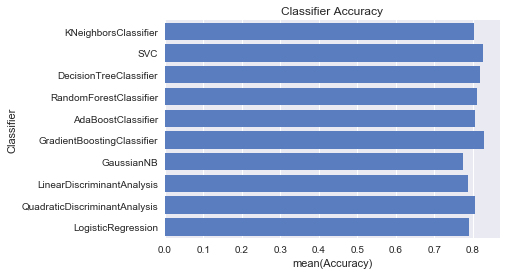

In [83]:
plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=acclog, color="b")

### Precision of Different Models

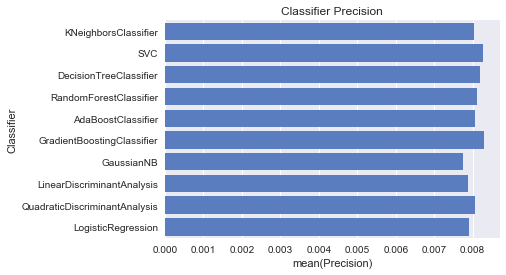

In [86]:
preclog_cols = ["Classifier", "Precision"]
preclog      = pd.DataFrame(columns=preclog_cols)

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)

prec_dict = {}

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    for clf in classifiers:
        name = clf.__class__.__name__
        clf.fit(X_train, y_train)
        train_predictions = clf.predict(X_test)
        prec = precision_score(y_test, train_predictions)
        if name in prec_dict:
            prec_dict[name] += prec
        else:
            prec_dict[name] = prec

for k in prec_dict:
    acc_dict[k] = acc_dict[k] / 10.0
    preclog = preclog.append(pd.DataFrame([[k, acc_dict[k]]], columns=preclog_cols))
    
plt.xlabel('Precision')
plt.title('Classifier Precision')

sns.set_color_codes("muted")
sns.barplot(x='Precision', y='Classifier', data=preclog, color="b")

In [85]:
preclog

,Classifier,Precision
0,KNeighborsClassifier,0.080444
0,SVC,0.082556
0,DecisionTreeClassifier,0.081889
0,RandomForestClassifier,0.081111
0,AdaBoostClassifier,0.080556
0,GradientBoostingClassifier,0.082889
0,GaussianNB,0.077444
0,LinearDiscriminantAnalysis,0.078667
0,QuadraticDiscriminantAnalysis,0.080556
0,LogisticRegression,0.079000


### Area under ROC Curve for Different Models

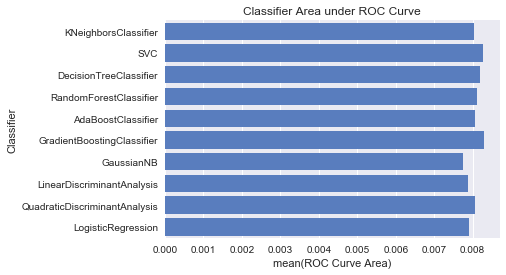

In [87]:
roclog_cols = ["Classifier", "ROC Curve Area"]
roclog      = pd.DataFrame(columns=roclog_cols)

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)

roc_dict = {}

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    for clf in classifiers:
        name = clf.__class__.__name__
        clf.fit(X_train, y_train)
        train_predictions = clf.predict(X_test)
        roc = roc_auc_score(y_test, train_predictions)
        if name in roc_dict:
            roc_dict[name] += roc
        else:
            roc_dict[name] = roc

for k in roc_dict:
    roc_dict[k] = roc_dict[k] / 10.0
    roclog = roclog.append(pd.DataFrame([[k, acc_dict[k]]], columns=roclog_cols))
    
plt.xlabel('Accuracy')
plt.title('Classifier Area under ROC Curve')

sns.set_color_codes("muted")
sns.barplot(x='ROC Curve Area', y='Classifier', data=roclog, color="b")

### Recall of Different Models

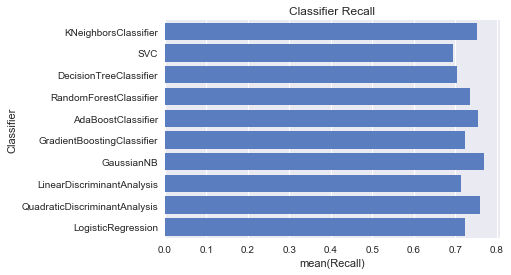

In [88]:
reclog_cols = ["Classifier", "Recall"]
reclog      = pd.DataFrame(columns=reclog_cols)

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)

rec_dict = {}

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    for clf in classifiers:
        name = clf.__class__.__name__
        clf.fit(X_train, y_train)
        train_predictions = clf.predict(X_test)
        rec = recall_score(y_test, train_predictions)
        if name in rec_dict:
            rec_dict[name] += rec
        else:
            rec_dict[name] = rec

for k in rec_dict:
    rec_dict[k] = rec_dict[k] / 10.0
    reclog = reclog.append(pd.DataFrame([[k, rec_dict[k]]], columns=reclog_cols))
    
plt.xlabel('Recall')
plt.title('Classifier Recall')

sns.set_color_codes("muted")
sns.barplot(x='Recall', y='Classifier', data=reclog, color="b")

### F1 of Different Models

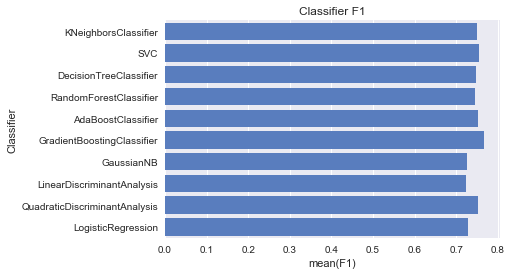

In [89]:
f1log_cols = ["Classifier", "F1"]
f1log      = pd.DataFrame(columns=f1log_cols)

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)

f1_dict = {}

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    for clf in classifiers:
        name = clf.__class__.__name__
        clf.fit(X_train, y_train)
        train_predictions = clf.predict(X_test)
        f1 = f1_score(y_test, train_predictions)
        if name in f1_dict:
            f1_dict[name] += f1
        else:
            f1_dict[name] = f1

for k in f1_dict:
    f1_dict[k] = f1_dict[k] / 10.0
    f1log = f1log.append(pd.DataFrame([[k, f1_dict[k]]], columns=f1log_cols))
    
plt.xlabel('F1')
plt.title('Classifier F1')

sns.set_color_codes("muted")
sns.barplot(x='F1', y='Classifier', data=f1log, color="b")

## Cross-Model Comparison Using Multiple Metrics

For this part, I will just normalize each of the models' 5 indicators I have chosen to look at to 1, and then add them up. this will allow me to see which performs the best overall.

In [103]:
logs = [acclog, preclog, roclog, reclog, f1log]
cols = [acclog_cols, preclog_cols, roclog_cols, reclog_cols, f1log_cols]
avgs = []
for i in range(len(logs)):
    avg = np.mean(logs[i][cols[i][1]])
    avgs.append(avg)

Now I have the average of each metric across all models. I just need to divide each model metric by the average across all models, so that they are meaningfully comparable.

In [131]:
newlogs = []
for i in range(len(logs)):
    norm = logs[i][cols[i][1]]/avgs[i]
    newlogs.append(np.array(norm))

Let's just check that this worked.

In [132]:
newlogs

[array([ 0.99917196,  1.02539332,  1.01711289,  1.00745239,  1.00055203,
         1.02953354,  0.96191002,  0.97709081,  1.00055203,  0.98123102]),
 array([ 0.99917196,  1.02539332,  1.01711289,  1.00745239,  1.00055203,
         1.02953354,  0.96191002,  0.97709081,  1.00055203,  0.98123102]),
 array([ 0.99917196,  1.02539332,  1.01711289,  1.00745239,  1.00055203,
         1.02953354,  0.96191002,  0.97709081,  1.00055203,  0.98123102]),
 array([ 1.02574103,  0.94773791,  0.95943838,  1.00234009,  1.02964119,
         0.98673947,  1.04914197,  0.975039  ,  1.0374415 ,  0.98673947]),
 array([ 1.0082433 ,  1.01424017,  1.00330065,  1.00107037,  1.00904045,
         1.02913491,  0.97595118,  0.97011568,  1.01089177,  0.97801153])]

Looks good. Now, I just need to create a list of classifier name strings and print each one with its score.

In [ ]:
clf_names = classifiers = [
    'KNeighborsClassifier',
    'SVC',
    'DecisionTreeClassifier',
    'RandomForestClassifier',
    'AdaBoostClassifier',
    'GradientBoostingClassifier',
    'GaussianNB',
    'LinearDiscriminantAnalysis',
    'QuadraticDiscriminantAnalysis',
    'LogisticRegression']

Here I can finally create the scores by adding up all the standardized scores for each model.

In [135]:
comp_scores = []
for j in range(len(clf_names)):
    comp_scores.append(np.sum([np.mean(newlogs[i][j]) for i in range(len(newlogs))]))

In [140]:
for i in range(len(clf_names)):
    print('{:32}: {:20}'.format(clf_names[i], comp_scores[i]))

KNeighborsClassifier            :    5.031500197039018
SVC                             :    5.038158039523772
DecisionTreeClassifier          :    5.014077696715684
RandomForestClassifier          :    5.025767627299695
AdaBoostClassifier              :    5.040337719213206
GradientBoostingClassifier      :    5.104474986001469
GaussianNB                      :    4.910823202519265
LinearDiscriminantAnalysis      :    4.876427105258959
QuadraticDiscriminantAnalysis   :    5.049989350343299
LogisticRegression              :    4.908444076085637


So the GradientBoostingClassifier seems to be the best. Let's use it for the submission.

In [141]:
candidate_classifier = GradientBoostingClassifier()
candidate_classifier.fit(train[0::, 1::], train[0::, 0])
result = candidate_classifier.predict(test)

I have the results. Now all I have to do is save them as a .csv file and upload them to Kaggle!

In [146]:
sub = pd.DataFrame()
sub['PassengerId'] = test_ID
sub['Survived'] = result
sub.to_csv('submission.csv',index=False)

All done! Now I know how to use a variety of classification models.